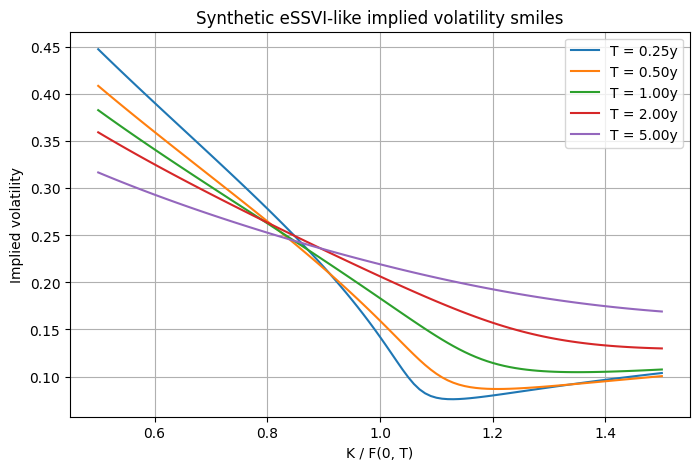

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

S0 = 100.0
maturities = np.array([0.25, 0.5, 1.0, 2.0, 5.0])  # 3м, 6м, 1г, 2г, 5л

x_grid = np.linspace(0.5, 1.5, 101)

def theta_T(T: float) -> float:

    sigma_atm = 0.12 + 0.10 * (1.0 - np.exp(-1.0 * T))
    return (sigma_atm ** 2) * T

def rho_of_theta(theta: float) -> float:

    rho_0 = -0.85
    rho_inf = -0.4
    a = 2.0
    return rho_inf + (rho_0 - rho_inf) * np.exp(-a * theta)

def phi_of_theta(theta: float) -> float:

    eta = 1.0
    lam = 0.5
    return eta * theta ** (-lam)

def essvi_total_variance(k: np.ndarray, T: float) -> np.ndarray:

    theta = theta_T(T)
    rho = rho_of_theta(theta)
    phi = phi_of_theta(theta)

    term = phi * k + rho
    inside_sqrt = term**2 + 1.0 - rho**2

    inside_sqrt = np.maximum(inside_sqrt, 0.0)

    w = 0.5 * theta * (1.0 + rho * phi * k + np.sqrt(inside_sqrt))
    return w

plt.figure(figsize=(8, 5))

for T in maturities:
    F = S0  # for simplicity we take F(0,T) ≈ S0, can be improved later
    k = np.log(x_grid)               # log-moneyness: log(K/F)
    w = essvi_total_variance(k, T)   # total variance
    sigma = np.sqrt(np.maximum(w, 0.0) / T)  # implied vol = sqrt(w / T)

    plt.plot(x_grid, sigma, label=f"T = {T:.2f}y")

plt.xlabel("K / F(0, T)")
plt.ylabel("Implied volatility")
plt.title("Synthetic eSSVI-like implied volatility smiles")
plt.grid(True)
plt.legend()
plt.show()


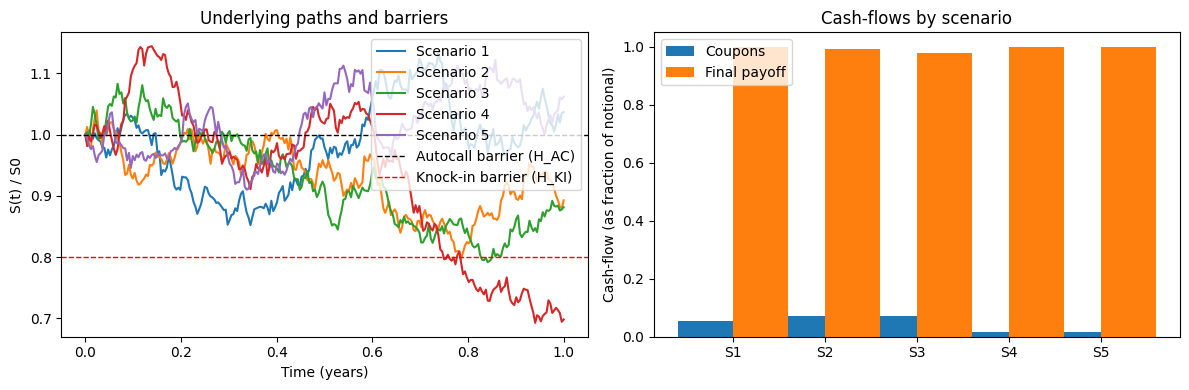

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Product parameters (as in the example from the article)
S0 = 100.0         # starting price
notional = 1.0     # we will work in fractions of the nominal value (=1) to make it easier

T_E = 1.0           # total term of the note (years), 1 year
T_O = 0.25          # observation step (quarter) -> 4 observations
N_obs = int(T_E / T_O)

K = 0.90            # strike in S0 shares (90%)
H_KI = 0.80         # knock-in barrier (80% S0)
H_AC = 1.00         # autocall-barrier (100% S0) for all dates
Y = 0.0719          # yearly coupon 7.19% p.a.
H_Y = 0.0           # coupon is guaranteed (no barrier)
Y_AC = 0.0          # autocall coupon = 0, like in the benchmark

# Model parameters for simulations
r = 0.01            # no risk bet
q = 0.00            # dividents
sigma = 0.20        # volatility

T = T_E
n_steps = 252
dt = T / n_steps


obs_indices = np.linspace(n_steps/N_obs, n_steps, N_obs, dtype=int) - 1  # 0-based indexes
obs_times = obs_indices * dt

# Simulation of GBM
def simulate_paths_gbm(S0, r, q, sigma, T, n_steps, n_paths, seed=42):
    np.random.seed(seed)
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

# Payoff
def abrc_cashflows_single_path(S_path):

    cashflows = []
    S0 = S_path[0]
    early_redeemed = False

    # yearly coupon Y -> throughout T_O we pay Y * T_O
    coupon_per_period = Y * T_O * notional

    # coupons + possible autocall
    for j, idx in enumerate(obs_indices):
        t = (idx + 1) * dt
        S_t = S_path[idx + 1]

        # guaranteed coupon
        if H_Y == 0.0 or S_t >= H_Y * S0:
            cashflows.append((t, coupon_per_period))

        # autocall
        if S_t >= H_AC * S0 and j < N_obs - 1:
            cashflows.append((t, notional + Y_AC * T_O * notional))
            early_redeemed = True
            break

    # if no autocall -> final payments in T_E
    if not early_redeemed:
        ST = S_path[-1]
        # continuous knock-in
        S_min = np.min(S_path)

        if S_min > H_KI * S0:
            # barrier not broken -> return nominal
            cashflows.append((T_E, notional))
        else:
            # barrier broken -> short put: economically, we get N shares at strike price K*S0
# number of "shares" as a fraction of par value:
# notional = N * K * S0 => N = notional / (K * S0)
            N_shares = notional / (K * S0)
            final_value = N_shares * ST
            cashflows.append((T_E, final_value))

    return cashflows

# We generate several scenarios and calculate cash flows
n_paths_demo = 5
paths = simulate_paths_gbm(S0, r, q, sigma, T, n_steps, n_paths_demo, seed=123)

all_cashflows = [abrc_cashflows_single_path(paths[i]) for i in range(n_paths_demo)]

time_grid = np.linspace(0, T, n_steps + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i in range(n_paths_demo):
    axes[0].plot(time_grid, paths[i] / S0, label=f"Scenario {i+1}")
axes[0].axhline(H_AC, color="k", linestyle="--", linewidth=1, label="Autocall barrier (H_AC)")
axes[0].axhline(H_KI, color="r", linestyle="--", linewidth=1, label="Knock-in barrier (H_KI)")
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("S(t) / S0")
axes[0].set_title("Underlying paths and barriers")
axes[0].legend(loc="upper right")

width = 0.6
scenario_indices = np.arange(n_paths_demo)

total_coupons = []
final_payoffs = []

for cf in all_cashflows:
    if len(cf) == 0:
        total_coupons.append(0.0)
        final_payoffs.append(0.0)
        continue
    *coupon_flows, final_flow = cf
    coupons_sum = sum(amount for (t, amount) in coupon_flows)
    total_coupons.append(coupons_sum)
    final_payoffs.append(final_flow[1])

axes[1].bar(scenario_indices - width/2, total_coupons, width=width, label="Coupons")
axes[1].bar(scenario_indices + width/2, final_payoffs, width=width, label="Final payoff")
axes[1].set_xticks(scenario_indices)
axes[1].set_xticklabels([f"S{i+1}" for i in range(n_paths_demo)])
axes[1].set_ylabel("Cash-flow (as fraction of notional)")
axes[1].set_title("Cash-flows by scenario")
axes[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Function for calculating the price using Monte Carlo
def price_abrc_bs(n_paths=20000, seed=12345):

    paths = simulate_paths_gbm(S0, r, q, sigma, T_E, n_steps, n_paths, seed=seed)

    discounted_payoffs = np.empty(n_paths)

    for i in range(n_paths):
        cashflows = abrc_cashflows_single_path(paths[i])
        pv = 0.0
        for t, amt in cashflows:
            pv += amt * np.exp(-r * t)
        discounted_payoffs[i] = pv

    price = discounted_payoffs.mean()
    se = discounted_payoffs.std(ddof=1) / np.sqrt(n_paths)
    return price, se

for n in [2000, 5000, 10000, 20000]:
    price, se = price_abrc_bs(n_paths=n, seed=100 + n)
    print(f"n_paths = {n:5d}  ->  price ≈ {price:.4f},  standard error ≈ {se:.4f}")


n_paths =  2000  ->  price ≈ 1.0102,  standard error ≈ 0.0014
n_paths =  5000  ->  price ≈ 1.0103,  standard error ≈ 0.0009
n_paths = 10000  ->  price ≈ 1.0099,  standard error ≈ 0.0006
n_paths = 20000  ->  price ≈ 1.0101,  standard error ≈ 0.0005


In [ ]:
import numpy as np

# Heston model parameters
kappa = 2.0   # mean reversion speed
theta = 0.04  # long-term average variance (i.e. vol ~ 20%)
eta   = 0.6   # vol-of-vol (let's make it pretty big)
rho   = -0.7  # negative correlation spot-vola
V0    = 0.04  # initial variance

# Simulation of Heston paths (full Euler truncation)
def simulate_paths_heston(S0, V0, kappa, theta, eta, rho, r, q, T, n_steps, n_paths, seed=42):
    np.random.seed(seed)
    dt = T / n_steps

    S = np.zeros((n_paths, n_steps + 1))
    V = np.zeros((n_paths, n_steps + 1))

    S[:, 0] = S0
    V[:, 0] = V0

    sqrt_dt = np.sqrt(dt)
    one_minus_rho2 = np.sqrt(1.0 - rho**2)

    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)

        dWv = sqrt_dt * z1
        dWs = sqrt_dt * (rho * z1 + one_minus_rho2 * z2)

        # full truncation for V_t
        V_prev_pos = np.maximum(V[:, t-1], 0.0)
        V[:, t] = V[:, t-1] + kappa * (theta - V_prev_pos) * dt + eta * np.sqrt(V_prev_pos) * dWv
        V[:, t] = np.maximum(V[:, t], 0.0)

        # log-Euler for S_t
        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * V_prev_pos) * dt + np.sqrt(V_prev_pos) * dWs)

    return S, V

# ABRC Pricing in Heston
def price_abrc_heston(n_paths=20000, seed=12345):
    paths_S, paths_V = simulate_paths_heston(
        S0, V0, kappa, theta, eta, rho, r, q, T_E, n_steps, n_paths, seed=seed
    )

    discounted_payoffs = np.empty(n_paths)

    for i in range(n_paths):
        cashflows = abrc_cashflows_single_path(paths_S[i])
        pv = 0.0
        for t, amt in cashflows:
            pv += amt * np.exp(-r * t)
        discounted_payoffs[i] = pv

    price = discounted_payoffs.mean()
    se = discounted_payoffs.std(ddof=1) / np.sqrt(n_paths)
    return price, se

# Compare BS(LV) and Heston(LSV-lite)
for n in [2000, 5000, 10000, 20000]:
    price_bs, se_bs = price_abrc_bs(n_paths=n, seed=100 + n)
    price_h, se_h = price_abrc_heston(n_paths=n, seed=200 + n)
    diff = price_h - price_bs
    diff_bps = diff * 1e4  # 1 bp = 0.0001
    print(f"n_paths = {n:5d} | BS ≈ {price_bs:.4f}, Heston ≈ {price_h:.4f}, "
          f"Δ ≈ {diff:.4f} ({diff_bps:.1f} bps)")


n_paths =  2000 | BS ≈ 1.0102, Heston ≈ 1.0063, Δ ≈ -0.0039 (-38.7 bps)
n_paths =  5000 | BS ≈ 1.0103, Heston ≈ 1.0076, Δ ≈ -0.0027 (-26.9 bps)
n_paths = 10000 | BS ≈ 1.0099, Heston ≈ 1.0062, Δ ≈ -0.0037 (-36.8 bps)
n_paths = 20000 | BS ≈ 1.0101, Heston ≈ 1.0052, Δ ≈ -0.0050 (-49.6 bps)



>>> Observation tenor T_O = 0.25 years
T_E = 1.0y:  BS ≈ 1.0093,  Heston ≈ 1.0063,  Δ ≈ -0.0029  (-29.5 bps)
T_E = 2.0y:  BS ≈ 1.0137,  Heston ≈ 1.0123,  Δ ≈ -0.0014  (-13.8 bps)
T_E = 3.0y:  BS ≈ 1.0222,  Heston ≈ 1.0189,  Δ ≈ -0.0032  (-32.5 bps)
T_E = 4.0y:  BS ≈ 1.0303,  Heston ≈ 1.0254,  Δ ≈ -0.0049  (-49.2 bps)
T_E = 5.0y:  BS ≈ 1.0375,  Heston ≈ 1.0309,  Δ ≈ -0.0067  (-66.5 bps)

>>> Observation tenor T_O = 0.5 years
T_E = 1.0y:  BS ≈ 1.0180,  Heston ≈ 1.0162,  Δ ≈ -0.0019  (-18.7 bps)
T_E = 2.0y:  BS ≈ 1.0272,  Heston ≈ 1.0218,  Δ ≈ -0.0054  (-54.3 bps)
T_E = 3.0y:  BS ≈ 1.0386,  Heston ≈ 1.0322,  Δ ≈ -0.0064  (-64.0 bps)
T_E = 4.0y:  BS ≈ 1.0462,  Heston ≈ 1.0393,  Δ ≈ -0.0069  (-69.1 bps)
T_E = 5.0y:  BS ≈ 1.0568,  Heston ≈ 1.0478,  Δ ≈ -0.0090  (-89.8 bps)

>>> Observation tenor T_O = 1.0 years
T_E = 1.0y:  BS ≈ 1.0331,  Heston ≈ 1.0293,  Δ ≈ -0.0038  (-37.8 bps)
T_E = 2.0y:  BS ≈ 1.0489,  Heston ≈ 1.0409,  Δ ≈ -0.0080  (-80.0 bps)
T_E = 3.0y:  BS ≈ 1.0628,  Heston ≈ 1.0558

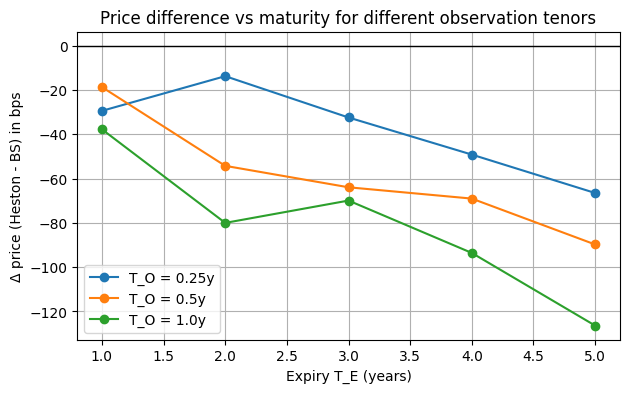

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# General product parameters (we fix, except T_E and T_O)
S0 = 100.0
notional = 1.0

K = 0.90      # put strike
H_KI = 0.80   # knock-in
H_AC = 1.00   # autocall-barrier
Y = 0.0719    # yearly coupon 7.19%
H_Y = 0.0     # coupon is guaranteed
Y_AC = 0.0    # autocall coupon = 0

r = 0.01
q = 0.00

# BS volatility (for LV baseline)
sigma = 0.20

# Heston parameters (LSV-lite)
kappa = 2.0
theta = 0.04
eta   = 0.6
rho   = -0.7
V0    = 0.04

# Numerical discretization
steps_per_year = 126  # less than 252, so it won't be too time-consuming

# New functions for simulation with arbitrary duration
def simulate_paths_gbm_T(S0, r, q, sigma, T, n_steps, n_paths, seed=42):
    np.random.seed(seed)
    dt = T / n_steps
    S = np.zeros((n_paths, n_steps + 1))
    S[:, 0] = S0
    for t in range(1, n_steps + 1):
        z = np.random.normal(size=n_paths)
        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

def simulate_paths_heston_T(S0, V0, kappa, theta, eta, rho, r, q, T, n_steps, n_paths, seed=42):
    np.random.seed(seed)
    dt = T / n_steps

    S = np.zeros((n_paths, n_steps + 1))
    V = np.zeros((n_paths, n_steps + 1))

    S[:, 0] = S0
    V[:, 0] = V0

    sqrt_dt = np.sqrt(dt)
    one_minus_rho2 = np.sqrt(1.0 - rho**2)

    for t in range(1, n_steps + 1):
        z1 = np.random.normal(size=n_paths)
        z2 = np.random.normal(size=n_paths)

        dWv = sqrt_dt * z1
        dWs = sqrt_dt * (rho * z1 + one_minus_rho2 * z2)

        V_prev_pos = np.maximum(V[:, t-1], 0.0)
        V[:, t] = V[:, t-1] + kappa * (theta - V_prev_pos) * dt + eta * np.sqrt(V_prev_pos) * dWv
        V[:, t] = np.maximum(V[:, t], 0.0)

        S[:, t] = S[:, t-1] * np.exp((r - q - 0.5 * V_prev_pos) * dt + np.sqrt(V_prev_pos) * dWs)

    return S

# Generalized ABRC payoff for arbitrary T_E and T_O
def abrc_cashflows_single_path_generic(S_path, T_E, T_O,
                                       K, H_KI, H_AC, Y, H_Y, Y_AC,
                                       steps_per_year=252, notional=1.0):
    cashflows = []
    S0 = S_path[0]

    obs_stride = int(round(T_O * steps_per_year))
    n_steps = S_path.shape[0] - 1
    n_obs = int(round(T_E / T_O))

    coupon_per_period = Y * T_O * notional
    early = False

    for j in range(n_obs):
        step = (j + 1) * obs_stride
        if step > n_steps:
            step = n_steps
        t = step / steps_per_year
        S_t = S_path[step]

        # coupon
        if H_Y == 0.0 or S_t >= H_Y * S0:
            cashflows.append((t, coupon_per_period))

        # autocall
        if S_t >= H_AC * S0 and j < n_obs - 1:
            cashflows.append((t, notional + Y_AC * T_O * notional))
            early = True
            break

    # final payment, if there was no autocall
    if not early:
        ST = S_path[-1]
        S_min = np.min(S_path)
        t_final = T_E

        if S_min > H_KI * S0:
            cashflows.append((t_final, notional))
        else:
            N_shares = notional / (K * S0)
            final_value = N_shares * ST
            cashflows.append((t_final, final_value))

    return cashflows

# Pricing functions BS and Heston for arbitrary T_E, T_O
def price_abrc_bs_generic(T_E, T_O, n_paths=8000, seed=1234):
    n_steps = int(round(T_E * steps_per_year))
    paths = simulate_paths_gbm_T(S0, r, q, sigma, T_E, n_steps, n_paths, seed=seed)

    discounted = np.empty(n_paths)
    for i in range(n_paths):
        cfs = abrc_cashflows_single_path_generic(
            paths[i], T_E, T_O,
            K, H_KI, H_AC, Y, H_Y, Y_AC,
            steps_per_year=steps_per_year, notional=notional
        )
        pv = 0.0
        for t, amt in cfs:
            pv += amt * np.exp(-r * t)
        discounted[i] = pv

    price = discounted.mean()
    se = discounted.std(ddof=1) / np.sqrt(n_paths)
    return price, se

def price_abrc_heston_generic(T_E, T_O, n_paths=8000, seed=5678):
    n_steps = int(round(T_E * steps_per_year))
    paths_S = simulate_paths_heston_T(
        S0, V0, kappa, theta, eta, rho, r, q, T_E, n_steps, n_paths, seed=seed
    )

    discounted = np.empty(n_paths)
    for i in range(n_paths):
        cfs = abrc_cashflows_single_path_generic(
            paths_S[i], T_E, T_O,
            K, H_KI, H_AC, Y, H_Y, Y_AC,
            steps_per_year=steps_per_year, notional=notional
        )
        pv = 0.0
        for t, amt in cfs:
            pv += amt * np.exp(-r * t)
        discounted[i] = pv

    price = discounted.mean()
    se = discounted.std(ddof=1) / np.sqrt(n_paths)
    return price, se

# Plotting Δ price vs T_E for different T_O
expiries_years = np.array([1, 2, 3, 4, 5])
observation_tenors = [0.25, 0.5, 1.0]  # 3м, 6м, 1г
colors = ["tab:blue", "tab:orange", "tab:green"]

diff_results = {}

for T_O in observation_tenors:
    diffs_bps = []
    print(f"\n>>> Observation tenor T_O = {T_O} years")
    for T_E in expiries_years:
        price_bs, se_bs = price_abrc_bs_generic(T_E, T_O, n_paths=8000, seed=int(1000*T_E + 10*T_O))
        price_h, se_h = price_abrc_heston_generic(T_E, T_O, n_paths=8000, seed=int(2000*T_E + 20*T_O))
        diff = price_h - price_bs
        diff_bps = diff * 1e4  # bps
        diffs_bps.append(diff_bps)
        print(f"T_E = {T_E:.1f}y:  BS ≈ {price_bs:.4f},  Heston ≈ {price_h:.4f},  "
              f"Δ ≈ {diff:.4f}  ({diff_bps:.1f} bps)")
    diff_results[T_O] = np.array(diffs_bps)

plt.figure(figsize=(7, 4))
for T_O, color in zip(observation_tenors, colors):
    plt.plot(expiries_years, diff_results[T_O], marker="o", label=f"T_O = {T_O}y", color=color)

plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Expiry T_E (years)")
plt.ylabel("Δ price (Heston - BS) in bps")
plt.title("Price difference vs maturity for different observation tenors")
plt.grid(True)
plt.legend()
plt.show()



>>> Knock-in barrier H = 0.5
T_E = 1.0y:  BS ≈ 1.0341,  Heston ≈ 1.0213,  Δ ≈ -0.0127  (-127.5 bps)
T_E = 2.0y:  BS ≈ 1.0448,  Heston ≈ 1.0213,  Δ ≈ -0.0235  (-235.3 bps)
T_E = 3.0y:  BS ≈ 1.0476,  Heston ≈ 1.0267,  Δ ≈ -0.0209  (-208.8 bps)
T_E = 4.0y:  BS ≈ 1.0475,  Heston ≈ 1.0295,  Δ ≈ -0.0180  (-179.7 bps)
T_E = 5.0y:  BS ≈ 1.0510,  Heston ≈ 1.0378,  Δ ≈ -0.0132  (-131.8 bps)

>>> Knock-in barrier H = 0.6
T_E = 1.0y:  BS ≈ 1.0313,  Heston ≈ 1.0133,  Δ ≈ -0.0180  (-180.3 bps)
T_E = 2.0y:  BS ≈ 1.0312,  Heston ≈ 1.0170,  Δ ≈ -0.0142  (-142.0 bps)
T_E = 3.0y:  BS ≈ 1.0316,  Heston ≈ 1.0210,  Δ ≈ -0.0106  (-106.4 bps)
T_E = 4.0y:  BS ≈ 1.0347,  Heston ≈ 1.0249,  Δ ≈ -0.0098  (-97.7 bps)
T_E = 5.0y:  BS ≈ 1.0401,  Heston ≈ 1.0299,  Δ ≈ -0.0102  (-102.1 bps)

>>> Knock-in barrier H = 0.7
T_E = 1.0y:  BS ≈ 1.0201,  Heston ≈ 1.0055,  Δ ≈ -0.0146  (-145.5 bps)
T_E = 2.0y:  BS ≈ 1.0187,  Heston ≈ 1.0141,  Δ ≈ -0.0046  (-45.8 bps)
T_E = 3.0y:  BS ≈ 1.0251,  Heston ≈ 1.0166,  Δ ≈ -0.0085  (-

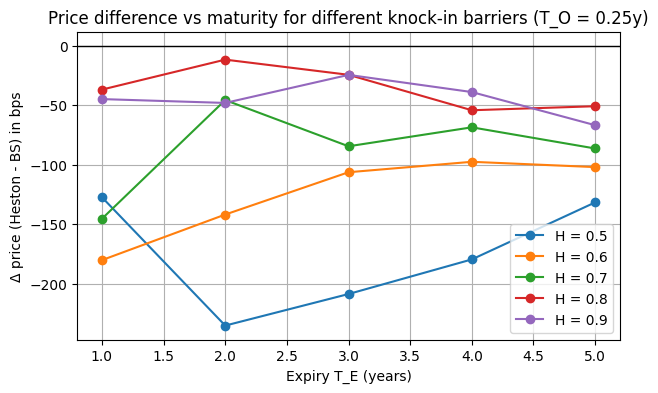

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We'll use the same steps_per_year, simulate_paths_gbm_T, simulate_paths_heston_T
# and abrc_cashflows_single_path_generic that are already in the notebook.

# Generic pricers with parameters K, H_KI, Y
def price_abrc_bs_param(T_E, T_O, K, H_KI, H_AC, Y, H_Y, Y_AC,
                        n_paths=6000, seed=1234):
    n_steps = int(round(T_E * steps_per_year))
    paths = simulate_paths_gbm_T(S0, r, q, sigma, T_E, n_steps, n_paths, seed=seed)

    discounted = np.empty(n_paths)
    for i in range(n_paths):
        cfs = abrc_cashflows_single_path_generic(
            paths[i], T_E, T_O,
            K, H_KI, H_AC, Y, H_Y, Y_AC,
            steps_per_year=steps_per_year, notional=notional
        )
        pv = 0.0
        for t, amt in cfs:
            pv += amt * np.exp(-r * t)
        discounted[i] = pv

    price = discounted.mean()
    se = discounted.std(ddof=1) / np.sqrt(n_paths)
    return price, se

def price_abrc_heston_param(T_E, T_O, K, H_KI, H_AC, Y, H_Y, Y_AC,
                            n_paths=6000, seed=5678):
    n_steps = int(round(T_E * steps_per_year))
    paths_S = simulate_paths_heston_T(
        S0, V0, kappa, theta, eta, rho, r, q, T_E, n_steps, n_paths, seed=seed
    )

    discounted = np.empty(n_paths)
    for i in range(n_paths):
        cfs = abrc_cashflows_single_path_generic(
            paths_S[i], T_E, T_O,
            K, H_KI, H_AC, Y, H_Y, Y_AC,
            steps_per_year=steps_per_year, notional=notional
        )
        pv = 0.0
        for t, amt in cfs:
            pv += amt * np.exp(-r * t)
        discounted[i] = pv

    price = discounted.mean()
    se = discounted.std(ddof=1) / np.sqrt(n_paths)
    return price, se

# Parameters for the experiment
expiries_years = np.array([1, 2, 3, 4, 5])      # different terms T_E
T_O_fixed = 0.25                                # observation tenor = 3 months
H_levels = [0.5, 0.6, 0.7, 0.8, 0.9]            # different knock-in barriers
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

diff_H_results = {}

# We calculate Δ price for different H and T_E
for H_KI_level in H_levels:
    diffs_bps = []
    print(f"\n>>> Knock-in barrier H = {H_KI_level:.1f}")
    for T_E in expiries_years:
        price_bs, _ = price_abrc_bs_param(
            T_E, T_O_fixed,
            K, H_KI_level, H_AC, Y, H_Y, Y_AC,
            n_paths=6000,
            seed=int(1000*T_E + 100*H_KI_level)
        )
        price_h, _ = price_abrc_heston_param(
            T_E, T_O_fixed,
            K, H_KI_level, H_AC, Y, H_Y, Y_AC,
            n_paths=6000,
            seed=int(2000*T_E + 200*H_KI_level)
        )
        diff = price_h - price_bs
        diff_bps = diff * 1e4
        diffs_bps.append(diff_bps)
        print(f"T_E = {T_E:.1f}y:  BS ≈ {price_bs:.4f},  Heston ≈ {price_h:.4f},  "
              f"Δ ≈ {diff:.4f}  ({diff_bps:.1f} bps)")
    diff_H_results[H_KI_level] = np.array(diffs_bps)

plt.figure(figsize=(7, 4))
for H_KI_level, color in zip(H_levels, colors):
    plt.plot(expiries_years, diff_H_results[H_KI_level],
             marker="o", label=f"H = {H_KI_level:.1f}", color=color)

plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Expiry T_E (years)")
plt.ylabel("Δ price (Heston - BS) in bps")
plt.title(f"Price difference vs maturity for different knock-in barriers (T_O = {T_O_fixed}y)")
plt.grid(True)
plt.legend()
plt.show()



>>> Coupon level Y = 0.0% p.a.
T_E = 1.0y:  BS ≈ 0.9701,  Heston ≈ 0.9723,  Δ ≈ 0.0021  (21.2 bps)
T_E = 2.0y:  BS ≈ 0.9577,  Heston ≈ 0.9600,  Δ ≈ 0.0023  (22.6 bps)
T_E = 3.0y:  BS ≈ 0.9520,  Heston ≈ 0.9596,  Δ ≈ 0.0076  (76.2 bps)
T_E = 4.0y:  BS ≈ 0.9465,  Heston ≈ 0.9556,  Δ ≈ 0.0091  (90.6 bps)
T_E = 5.0y:  BS ≈ 0.9465,  Heston ≈ 0.9554,  Δ ≈ 0.0088  (88.2 bps)

>>> Coupon level Y = 3.0% p.a.
T_E = 1.0y:  BS ≈ 0.9850,  Heston ≈ 0.9862,  Δ ≈ 0.0012  (12.0 bps)
T_E = 2.0y:  BS ≈ 0.9797,  Heston ≈ 0.9843,  Δ ≈ 0.0046  (45.8 bps)
T_E = 3.0y:  BS ≈ 0.9821,  Heston ≈ 0.9816,  Δ ≈ -0.0005  (-4.8 bps)
T_E = 4.0y:  BS ≈ 0.9834,  Heston ≈ 0.9842,  Δ ≈ 0.0008  (8.3 bps)
T_E = 5.0y:  BS ≈ 0.9858,  Heston ≈ 0.9855,  Δ ≈ -0.0003  (-3.3 bps)

>>> Coupon level Y = 6.0% p.a.
T_E = 1.0y:  BS ≈ 1.0022,  Heston ≈ 0.9976,  Δ ≈ -0.0045  (-45.4 bps)
T_E = 2.0y:  BS ≈ 1.0053,  Heston ≈ 1.0027,  Δ ≈ -0.0027  (-26.7 bps)
T_E = 3.0y:  BS ≈ 1.0100,  Heston ≈ 1.0075,  Δ ≈ -0.0025  (-25.4 bps)
T_E = 4.0y:  

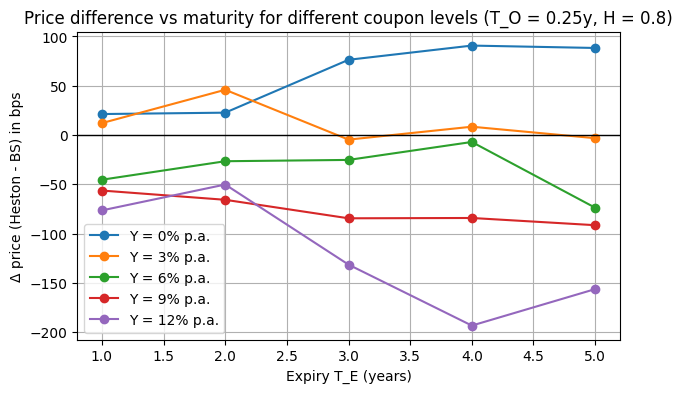

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Using the already defined ones:
# price_abrc_bs_param, price_abrc_heston_param, steps_per_year, S0, r, q, K, H_KI, H_AC, H_Y, Y_AC, notional

# Experiment settings
expiries_years = np.array([1, 2, 3, 4, 5])   # terms T_E
T_O_fixed = 0.25                             # observation tenor = 3 months
H_KI_fixed = 0.8                             # we fix the knock-in at 80%
H_AC_fixed = 1.0                             # autocall-barrier is still 100%
H_Y_fixed = 0.0                              # coupon is guaranteed
Y_AC_fixed = 0.0                             # w/o extra coupon

# Let's take several levels of annual coupon (from low to high)
Y_levels = [0.00, 0.03, 0.06, 0.09, 0.12]  # 0%, 3%, 6%, 9%, 12% per annum
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

diff_Y_results = {}

# We calculate Δ price for different Y and T_E
for Y_level in Y_levels:
    diffs_bps = []
    print(f"\n>>> Coupon level Y = {Y_level*100:.1f}% p.a.")
    for T_E in expiries_years:
        price_bs, _ = price_abrc_bs_param(
            T_E, T_O_fixed,
            K, H_KI_fixed, H_AC_fixed, Y_level, H_Y_fixed, Y_AC_fixed,
            n_paths=6000,
            seed=int(1000*T_E + 100*Y_level*100)
        )
        price_h, _ = price_abrc_heston_param(
            T_E, T_O_fixed,
            K, H_KI_fixed, H_AC_fixed, Y_level, H_Y_fixed, Y_AC_fixed,
            n_paths=6000,
            seed=int(2000*T_E + 200*Y_level*100)
        )
        diff = price_h - price_bs
        diff_bps = diff * 1e4
        diffs_bps.append(diff_bps)
        print(f"T_E = {T_E:.1f}y:  BS ≈ {price_bs:.4f},  Heston ≈ {price_h:.4f},  "
              f"Δ ≈ {diff:.4f}  ({diff_bps:.1f} bps)")
    diff_Y_results[Y_level] = np.array(diffs_bps)

plt.figure(figsize=(7, 4))
for Y_level, color in zip(Y_levels, colors):
    label = f"Y = {Y_level*100:.0f}% p.a."
    plt.plot(expiries_years, diff_Y_results[Y_level],
             marker="o", label=label, color=color)

plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Expiry T_E (years)")
plt.ylabel("Δ price (Heston - BS) in bps")
plt.title(f"Price difference vs maturity for different coupon levels (T_O = {T_O_fixed}y, H = {H_KI_fixed})")
plt.grid(True)
plt.legend()
plt.show()



>>> Coupon barrier H_Y = 0.0
T_E = 1.0y:  BS ≈ 1.0201,  Heston ≈ 1.0159,  Δ ≈ -0.0042  (-41.9 bps)
T_E = 2.0y:  BS ≈ 1.0292,  Heston ≈ 1.0220,  Δ ≈ -0.0071  (-71.4 bps)
T_E = 3.0y:  BS ≈ 1.0409,  Heston ≈ 1.0341,  Δ ≈ -0.0068  (-67.9 bps)
T_E = 4.0y:  BS ≈ 1.0523,  Heston ≈ 1.0430,  Δ ≈ -0.0093  (-93.4 bps)
T_E = 5.0y:  BS ≈ 1.0605,  Heston ≈ 1.0521,  Δ ≈ -0.0084  (-83.6 bps)

>>> Coupon barrier H_Y = 0.6
T_E = 1.0y:  BS ≈ 1.0194,  Heston ≈ 1.0124,  Δ ≈ -0.0070  (-69.6 bps)
T_E = 2.0y:  BS ≈ 1.0278,  Heston ≈ 1.0213,  Δ ≈ -0.0065  (-64.9 bps)
T_E = 3.0y:  BS ≈ 1.0340,  Heston ≈ 1.0258,  Δ ≈ -0.0083  (-82.6 bps)
T_E = 4.0y:  BS ≈ 1.0393,  Heston ≈ 1.0290,  Δ ≈ -0.0103  (-102.7 bps)
T_E = 5.0y:  BS ≈ 1.0428,  Heston ≈ 1.0332,  Δ ≈ -0.0096  (-95.6 bps)

>>> Coupon barrier H_Y = 0.8
T_E = 1.0y:  BS ≈ 1.0129,  Heston ≈ 1.0085,  Δ ≈ -0.0044  (-43.6 bps)
T_E = 2.0y:  BS ≈ 1.0115,  Heston ≈ 1.0083,  Δ ≈ -0.0031  (-31.5 bps)
T_E = 3.0y:  BS ≈ 1.0094,  Heston ≈ 1.0074,  Δ ≈ -0.0020  (-20.0 bps)

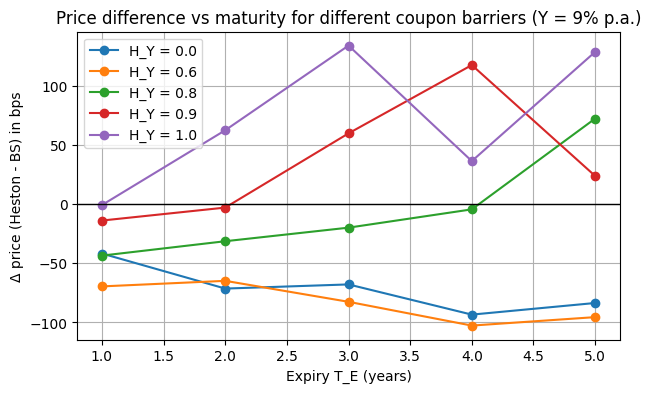

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Experiment settings
expiries_years = np.array([1, 2, 3, 4, 5])
T_O_fixed = 0.25

K_fixed = 0.90
H_KI_fixed = 0.8
H_AC_fixed = 1.0

Y_fixed = 0.09       # we fix a relatively high coupon of 9% p.a.
Y_AC_fixed = 0.0

# Coupon barriers (in S0 fractions): 0 = guaranteed coupon
H_Y_levels = [0.0, 0.6, 0.8, 0.9, 1.0]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

diff_HY_results = {}

for H_Y_level in H_Y_levels:
    diffs_bps = []
    print(f"\n>>> Coupon barrier H_Y = {H_Y_level:.1f}")
    for T_E in expiries_years:
        price_bs, _ = price_abrc_bs_param(
            T_E, T_O_fixed,
            K_fixed, H_KI_fixed, H_AC_fixed, Y_fixed, H_Y_level, Y_AC_fixed,
            n_paths=6000,
            seed=int(1000*T_E + 100*H_Y_level*100)
        )
        price_h, _ = price_abrc_heston_param(
            T_E, T_O_fixed,
            K_fixed, H_KI_fixed, H_AC_fixed, Y_fixed, H_Y_level, Y_AC_fixed,
            n_paths=6000,
            seed=int(2000*T_E + 200*H_Y_level*100)
        )
        diff = price_h - price_bs
        diff_bps = diff * 1e4
        diffs_bps.append(diff_bps)
        print(f"T_E = {T_E:.1f}y:  BS ≈ {price_bs:.4f},  Heston ≈ {price_h:.4f},  "
              f"Δ ≈ {diff:.4f}  ({diff_bps:.1f} bps)")
    diff_HY_results[H_Y_level] = np.array(diffs_bps)

plt.figure(figsize=(7, 4))
for H_Y_level, color in zip(H_Y_levels, colors):
    label = f"H_Y = {H_Y_level:.1f}"
    plt.plot(expiries_years, diff_HY_results[H_Y_level],
             marker="o", label=label, color=color)

plt.axhline(0.0, color="black", linewidth=1)
plt.xlabel("Expiry T_E (years)")
plt.ylabel("Δ price (Heston - BS) in bps")
plt.title(f"Price difference vs maturity for different coupon barriers (Y = {Y_fixed*100:.0f}% p.a.)")
plt.grid(True)
plt.legend()
plt.show()


## 4. Numerical results

### 4.1 Synthetic implied volatility surface

As a first step, we construct a synthetic implied volatility (IV) surface using an eSSVI–type parametrisation. For a set of maturities  
$T \in \{0.25, 0.5, 1, 2, 5\}$ years we specify the term structure of at-the-money (ATM) total variance $\theta_T$ and the functions $\rho(\theta_T)$ and $\varphi(\theta_T)$ controlling the skew and the curvature of the smile. The resulting implied volatilities $\hat\sigma(K,T)$ are plotted against the forward moneyness $K/F(0,T)$ in Figure 1.

The generated smiles exhibit the usual equity–index features: a pronounced downside skew (higher volatilities for $K/F<1$), a mild upturn for far out-of-the-money calls, and an upward-sloping ATM term structure. This confirms that the synthetic surface is qualitatively consistent with typical SPX/Eurostoxx smiles and can be used as a reasonable proxy for further experiments.

### 4.2 Autocallable payoff and pathwise behaviour

We consider an autocallable barrier reverse convertible (ABRC) with maturity $T^E = 1$ year, quarterly observation dates $T^O = 0.25$, strike $K = 90\%$, down-and-in barrier $H = 80\%$ and autocall barrier $H^{AC} = 100\%$ of the initial spot. The note pays a fixed yearly coupon $Y = 7.19\%$ pro-rated over observation periods; coupons are unconditional ($H^Y=0$), and there is no additional autocall coupon ($Y^{AC}=0$).

Figure 2 shows a set of simulated underlying paths under a geometric Brownian motion together with the knock-in and autocall barriers, as well as the resulting cash–flows per scenario. The scenarios illustrate the typical regimes of an ABRC:

- early redemption when the underlying trades above the autocall barrier at an observation date, with repayment of notional plus accrued coupon;
- full redemption at maturity if no knock-in has occurred and the final spot remains above the barrier;
- loss of notional proportional to the negative performance below the strike when the knock-in barrier has been breached and the final spot is low.

This figure is mainly used to build intuition about the path-dependence of the structure.

### 4.3 Black–Scholes vs Heston benchmark prices

We take a Black–Scholes (BS) model with constant volatility $\sigma = 20\%$ as a proxy for a local–volatility (LV) model, and a Heston stochastic volatility model with parameters  
$(\kappa, \theta, \eta, \rho, V_0) = (2.0, 0.04, 0.6, -0.7, 0.04)$ as an LSV-lite benchmark. Prices are computed by Monte Carlo simulation with daily (or sub-daily) time steps and up to 20,000 paths.

For the one-year benchmark ABRC described above we obtain a BS price of approximately 1.01 (in units of notional) and a Heston price around 1.01 as well, with a small negative difference of order −30 to −50 basis points depending on the number of paths. In contrast to the original paper, where the LSV model typically yields higher prices than LV, our Heston model produces slightly *lower* prices. This is expected, since in our setup the two models are not jointly calibrated to the same IV surface; the chosen Heston parameters amplify downside risk relative to the BS benchmark and therefore reduce the expected payoff of a product that is effectively long coupons and short downside options.

The remaining experiments focus on how this BS–Heston price difference depends on structural product features.

### 4.4 Sensitivity to maturity and observation frequency

We first vary the final maturity $T^E \in \{1,2,3,4,5\}$ years and the observation tenor $T^O \in \{0.25, 0.5, 1.0\}$ years, keeping all other contract parameters fixed. Figure 3 plots the price difference  
\[
\Delta(T^E, T^O) = U^{\text{Heston}}(0) - U^{\text{BS}}(0)
\]
in basis points.

For all tenors and maturities the difference is negative, and its absolute value increases both with $T^E$ and with less frequent observations. For quarterly observations the effect ranges from about −30 bps for a 1-year note to roughly −70 bps at 5 years, while for annual observations it reaches around −120 bps at the long end. Intuitively, longer maturities and sparser autocall dates imply that the note spends more time exposed to stochastic volatility and to the possibility of large downward moves, which is precisely where the Heston dynamics deviate most from the BS benchmark.

### 4.5 Sensitivity to knock-in barrier

Next we fix $T^O = 0.25$ and vary the knock-in barrier level  
$H \in \{50\%, 60\%, 70\%, 80\%, 90\%\}$ while keeping the strike at 90%. The corresponding price differences as a function of maturity are shown in Figure 4.

The results show that the magnitude of the BS–Heston discrepancy strongly depends on the barrier level. Deep barriers (e.g. $H = 50\%$) produce large negative differences, between roughly −130 and −230 bps, as the Heston model generates more paths that experience severe drawdowns and thus trigger the knock-in. As the barrier moves closer to the initial spot (e.g. $H = 80\%$ or $90\%$), the effect becomes smaller in absolute value and more stable across maturities (around −20 to −70 bps). Overall, the knock-in level is a key driver of model risk for ABRCs.

### 4.6 Sensitivity to coupon level

We then vary the annual coupon rate $Y \in \{0\%, 3\%, 6\%, 9\%, 12\%\}$ for a fixed structure with $H=80\%$ and $T^O = 0.25$. Figure 5 reports $\Delta(T^E,Y)$ in basis points.

When $Y = 0\%$ (the structure reduces to a pure capital-protected note with embedded down-and-in option), the Heston price exceeds the BS price by about 20–90 bps, and the difference increases with maturity. For low coupons around 3% the models give very similar prices. For higher coupons (6–12%) the sign flips: $\Delta$ becomes negative and its magnitude grows with both maturity and coupon level, reaching roughly −150 to −200 bps for $Y = 12\%$. This reflects the fact that higher coupons effectively increase the short-volatility and short-skew exposure of the note; in our parameterisation the Heston dynamics produce more severe downside scenarios than BS, so the expected value of these larger coupon streams is more heavily penalised.

In summary, the coupon rate substantially amplifies model risk: richer coupons lead to much larger BS–Heston discrepancies.

### 4.7 Sensitivity to coupon barrier

Finally, we investigate the impact of conditioning coupon payments on the underlying level. We fix a relatively high coupon $Y = 9\%$ and vary the coupon barrier  
$H^Y \in \{0, 60\%, 80\%, 90\%, 100\%\}$, again for $T^O = 0.25$. Figure 6 shows the price difference as a function of maturity.

With guaranteed coupons ($H^Y=0$) the difference is negative and of order −40 to −90 bps. Introducing a moderate coupon barrier at 60–80% does not change the sign but slightly increases the magnitude, indicating stronger path-dependence. For high barriers ($H^Y = 90\%$ and $100\%$) the behaviour changes qualitatively: for medium and long maturities the difference becomes positive and can exceed +100 bps. In these cases coupons are only paid in “good states” of the world, and the Heston model, with its richer volatility dynamics, assigns more weight to such states relative to BS.

These experiments show that coupon barriers can both increase the absolute size of the BS–Heston discrepancy and even reverse its sign. Consequently, coupon features play an important role in the model risk profile of autocallables.
